In [1]:
# Install XGBoost if needed
!pip install xgboost --quiet

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time


# Load the data
df = pd.read_csv('men_2026_matchups_training.csv')


print(f"\nTotal games: {len(df)}")
print(f"Class distribution:\n{df['win'].value_counts()}")


Total games: 1254
Class distribution:
win
1    627
0    627
Name: count, dtype: int64


In [2]:
# Define features
features = [
'5man_bpm',
'3man_bpm',
'torvik_rtg',
'wab',
'kenpom_rtg',
'3man_dbpm',
'5man_dbpm',
'5man_obpm',
'torvik_def',
'torvik_off',
'kenpom_off',
'experience_weighted_production',
'lineup_depth_quality',
'def_lineup_depth_quality',
'3man_obpm',
'bench',
'bench_scoring_ratio',
'kenpom_def',
'def_experience_impact',
'rotation_balance',
'size',
'def_rim_to_three_ratio',
'ftrd',
'effective_possession_rate',
'5man_dprpg',
'def_shot_quality_variance',
'rim_to_three_ratio',
'off_dunk_share',
'def_dunk_share',
'blked_pct',
'ftr',
'ast_pct',
'four_factors_composite',
'efgd_pct',
'assist_to_usage_ratio',
'off_close2_fg_pct',
'off_far2_fg_pct',
'drb_pct',
'def_assist_suppression',
'2p_pct',
'def_close2_fg_pct',
'off_close2_share',
'offensive_versatility_score',
'experience',
'def_four_factors_composite',
'adj_tempo',
'size_speed_index',
'off_far2_share',
'defensive_versatility_score',
'efg_pct',
'def_effective_possession_rate',
'def_size_speed_index',
'elite_outcome_probability',
'perimeter_efficiency',
'def_3pt_fg_pct',
'def_perimeter_efficiency',
'off_3pt_fg_pct',
'def_rim_efficiency',
'rim_efficiency',
'blk_pct',
'orb_pct',
]

print(f"\nNumber of features: {len(features)}")

X = df[features]
y = df['win']
X = X.fillna(X.median())

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42, stratify=y_temp)

print(f"\nTrain: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Number of features: 61

Train: 873 | Val: 192 | Test: 189


In [3]:
# =============================================================================
# STAGE 1: BROAD SEARCH
# =============================================================================
print("\n" + "="*80)
print("STAGE 1: BROAD SEARCH")
print("="*80 + "\n")

param_distributions_stage1 = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 400, 500, 700, 1000],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 18, 20],
    'learning_rate': [0.001, 0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.07, 0.1, 0.15, 0.20, 0.25],
    'reg_alpha': [0, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0, 30.0],
    'reg_lambda': [0, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0, 30.0, 50.0],
    'subsample': [0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],
    'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bynode': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50],
    'gamma': [0, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0],
    'max_delta_step': [0, 1, 5, 10],
    'scale_pos_weight': [0.5, 1.0, 2.0, 3.0, 5.0],
}

xgb_stage1 = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    eval_metric='logloss',
    enable_categorical=False
)

random_search_stage1 = RandomizedSearchCV(
    estimator=xgb_stage1,
    param_distributions=param_distributions_stage1,
    n_iter=500,
    cv=4,
    scoring='accuracy',
    n_jobs=1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

stage1_start = time.time()
print(f"Stage 1 started at: {time.strftime('%H:%M:%S')}")
random_search_stage1.fit(X_train_scaled, y_train)
stage1_time = time.time() - stage1_start

best_params_stage1 = random_search_stage1.best_params_

print(f"\n{'='*80}")
print(f"STAGE 1 COMPLETE - Actual Time: {stage1_time/60:.1f} minutes")
print(f"{'='*80}")
print(f"Best CV Score: {random_search_stage1.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in best_params_stage1.items():
    print(f"  {param}: {value}")

stage1_model = random_search_stage1.best_estimator_
stage1_train = stage1_model.score(X_train_scaled, y_train)
stage1_val = stage1_model.score(X_val_scaled, y_val)
print(f"\nOverfitting Check: Train={stage1_train:.4f} | Val={stage1_val:.4f} | Gap={stage1_train - stage1_val:.4f}")



STAGE 1: BROAD SEARCH
Iterations: 40 | CV Folds: 3 | Total Fits: 120
Expected Time: 40-55 minutes

Stage 1 started at: 14:06:55
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [14:06:55] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END colsample_bylevel=0.5, colsample_bynode=0.4, colsample_bytree=0.6, gamma=10.0, learning_rate=0.15, max_delta_step=10, max_depth=15, min_child_weight=5, n_estimators=200, reg_alpha=0.01, reg_lambda=1.0, scale_pos_weight=1.0, subsample=0.9; total time=   0.8s
[CV] END colsample_bylevel=0.5, colsample_bynode=0.4, colsample_bytree=0.6, gamma=10.0, learning_rate=0.15, max_delta_step=10, max_depth=15, min_child_weight=5, n_estimators=200, reg_alpha=0.01, reg_lambda=1.0, scale_pos_weight=1.0, subsample=0.9; total time=   0.3s
[CV] END colsample_bylevel=0.5, colsample_bynode=0.4, colsample_bytree=0.6, gamma=10.0, learning_rate=0.15, max_delta_step=10, max_depth=15, min_child_weight=5, n_estimators=200, reg_alpha=0.01, reg_lambda=1.0, scale_pos_weight=1.0, subsample=0.9; total time=   0.5s
[CV] END colsample_bylevel=0.5, colsample_bynode=0.4, colsample_bytree=0.6, gamma=10.0, learning_rate=0.15, max_delta_step=10, max_depth=15, min_child_weight=5, n_estimators=200, reg_alpha=0.01, reg_

In [4]:
# =============================================================================
# STAGE 2: FOCUSED SEARCH AROUND BEST PARAMS
# =============================================================================
print("\n" + "="*80)
print("STAGE 2: FOCUSED SEARCH")
print("="*80 + "\n")

def get_range(value, options_list, expand_by=2):
    if value is None:
        return [None]
    if value not in options_list:
        return [value]

    idx = options_list.index(value)
    start_idx = max(0, idx - expand_by)
    end_idx = min(len(options_list), idx + expand_by + 1)
    return options_list[start_idx:end_idx]

n_estimators_opts = [50, 100, 150, 200, 250, 300, 400, 500, 700, 1000, 1500]
max_depth_opts = [2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 20]
learning_rate_opts = [0.001, 0.005, 0.008, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.07, 0.1, 0.15]
reg_alpha_opts = [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0, 30.0, 50.0]
reg_lambda_opts = [0, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0, 30.0, 50.0, 70.0]
subsample_opts = [0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
colsample_bytree_opts = [0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
colsample_bylevel_opts = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colsample_bynode_opts = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
min_child_weight_opts = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50]
gamma_opts = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0]
max_delta_step_opts = [0, 1, 3, 5, 10]
scale_pos_weight_opts = [0.5, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0]

param_distributions_stage2 = {
    'n_estimators': get_range(best_params_stage1['n_estimators'], n_estimators_opts, 2),
    'max_depth': get_range(best_params_stage1['max_depth'], max_depth_opts, 2),
    'learning_rate': get_range(best_params_stage1['learning_rate'], learning_rate_opts, 3),
    'reg_alpha': get_range(best_params_stage1['reg_alpha'], reg_alpha_opts, 3),
    'reg_lambda': get_range(best_params_stage1['reg_lambda'], reg_lambda_opts, 3),
    'subsample': get_range(best_params_stage1['subsample'], subsample_opts, 3),
    'colsample_bytree': get_range(best_params_stage1['colsample_bytree'], colsample_bytree_opts, 3),
    'colsample_bylevel': get_range(best_params_stage1.get('colsample_bylevel', 0.7), colsample_bylevel_opts, 2),
    'colsample_bynode': get_range(best_params_stage1.get('colsample_bynode', 0.7), colsample_bynode_opts, 2),
    'min_child_weight': get_range(best_params_stage1['min_child_weight'], min_child_weight_opts, 3),
    'gamma': get_range(best_params_stage1['gamma'], gamma_opts, 3),
    'max_delta_step': get_range(best_params_stage1.get('max_delta_step', 0), max_delta_step_opts, 1),
    'scale_pos_weight': get_range(best_params_stage1.get('scale_pos_weight', 1.0), scale_pos_weight_opts, 2),
}

print(f"Stage 2 Search Space:")
for param, values in param_distributions_stage2.items():
    print(f"  {param}: {values}")

xgb_stage2 = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    eval_metric='logloss',
    enable_categorical=False
)

random_search_stage2 = RandomizedSearchCV(
    estimator=xgb_stage2,
    param_distributions=param_distributions_stage2,
    n_iter=1000,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=2,
    random_state=43,
    return_train_score=True
)

stage2_start = time.time()
print(f"Stage 2 started at: {time.strftime('%H:%M:%S')}")
random_search_stage2.fit(X_train_scaled, y_train)
stage2_time = time.time() - stage2_start

best_params_stage2 = random_search_stage2.best_params_

print(f"\n{'='*80}")
print(f"STAGE 2 COMPLETE - Actual Time: {stage2_time/60:.1f} minutes")
print(f"{'='*80}")
print(f"Best CV Score: {random_search_stage2.best_score_:.4f}")
print(f"Improvement: {random_search_stage2.best_score_ - random_search_stage1.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in best_params_stage2.items():
    print(f"  {param}: {value}")

stage2_model = random_search_stage2.best_estimator_
stage2_train = stage2_model.score(X_train_scaled, y_train)
stage2_val = stage2_model.score(X_val_scaled, y_val)
print(f"\nOverfitting Check: Train={stage2_train:.4f} | Val={stage2_val:.4f} | Gap={stage2_train - stage2_val:.4f}")


Streaming output truncated to the last 5000 lines.
[CV] END colsample_bylevel=0.8, colsample_bynode=0.7, colsample_bytree=0.7, gamma=1.0, learning_rate=0.01, max_delta_step=1, max_depth=15, min_child_weight=40, n_estimators=100, reg_alpha=15.0, reg_lambda=50.0, scale_pos_weight=1.5, subsample=0.5; total time=   0.3s
[CV] END colsample_bylevel=0.8, colsample_bynode=0.7, colsample_bytree=0.7, gamma=1.0, learning_rate=0.01, max_delta_step=1, max_depth=15, min_child_weight=40, n_estimators=100, reg_alpha=15.0, reg_lambda=50.0, scale_pos_weight=1.5, subsample=0.5; total time=   0.3s
[CV] END colsample_bylevel=0.8, colsample_bynode=0.9, colsample_bytree=0.7, gamma=0.2, learning_rate=0.001, max_delta_step=1, max_depth=12, min_child_weight=30, n_estimators=250, reg_alpha=15.0, reg_lambda=30.0, scale_pos_weight=1.5, subsample=0.55; total time=   0.7s
[CV] END colsample_bylevel=0.8, colsample_bynode=0.9, colsample_bytree=0.7, gamma=0.2, learning_rate=0.001, max_delta_step=1, max_depth=12, min_ch

In [5]:
# =============================================================================
# STAGE 3: FINE-TUNING WITH HIGHER CV
# =============================================================================
print("\n" + "="*80)
print("STAGE 3: FINE-TUNING")
print("="*80 + "\n")

param_distributions_stage3 = {
    'n_estimators': get_range(best_params_stage2['n_estimators'], n_estimators_opts, 1),
    'max_depth': get_range(best_params_stage2['max_depth'], max_depth_opts, 1),
    'learning_rate': get_range(best_params_stage2['learning_rate'], learning_rate_opts, 2),
    'reg_alpha': get_range(best_params_stage2['reg_alpha'], reg_alpha_opts, 2),
    'reg_lambda': get_range(best_params_stage2['reg_lambda'], reg_lambda_opts, 2),
    'subsample': get_range(best_params_stage2['subsample'], subsample_opts, 2),
    'colsample_bytree': get_range(best_params_stage2['colsample_bytree'], colsample_bytree_opts, 2),
    'colsample_bylevel': get_range(best_params_stage2.get('colsample_bylevel', 0.7), colsample_bylevel_opts, 1),
    'colsample_bynode': get_range(best_params_stage2.get('colsample_bynode', 0.7), colsample_bynode_opts, 1),
    'min_child_weight': get_range(best_params_stage2['min_child_weight'], min_child_weight_opts, 2),
    'gamma': get_range(best_params_stage2['gamma'], gamma_opts, 2),
    'max_delta_step': get_range(best_params_stage2.get('max_delta_step', 0), max_delta_step_opts, 1),
    'scale_pos_weight': get_range(best_params_stage2.get('scale_pos_weight', 1.0), scale_pos_weight_opts, 1),
}

print(f"Stage 3 Search Space:")
for param, values in param_distributions_stage3.items():
    print(f"  {param}: {values}")

xgb_stage3 = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    eval_metric='logloss',
    enable_categorical=False
)

random_search_stage3 = RandomizedSearchCV(
    estimator=xgb_stage3,
    param_distributions=param_distributions_stage3,
    n_iter=2000,
    cv=4,
    scoring='accuracy',
    n_jobs=1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

stage3_start = time.time()
print(f"Stage 3 started at: {time.strftime('%H:%M:%S')}")
random_search_stage3.fit(X_train_scaled, y_train)
stage3_time = time.time() - stage3_start

print(f"\n{'='*80}")
print(f"STAGE 3 COMPLETE - Actual Time: {stage3_time/60:.1f} minutes")
print(f"{'='*80}")
print(f"Best CV Score: {random_search_stage3.best_score_:.4f}")
print(f"Improvement: {random_search_stage3.best_score_ - random_search_stage2.best_score_:.4f}")
print(f"\nFinal Best Parameters:")
for param, value in random_search_stage3.best_params_.items():
    print(f"  {param}: {value}")

Streaming output truncated to the last 5000 lines.
[CV] END colsample_bylevel=0.6, colsample_bynode=0.8, colsample_bytree=0.5, gamma=0.01, learning_rate=0.02, max_delta_step=1, max_depth=15, min_child_weight=40, n_estimators=200, reg_alpha=50.0, reg_lambda=50.0, scale_pos_weight=1.0, subsample=0.6; total time=   0.2s
[CV] END colsample_bylevel=0.6, colsample_bynode=0.8, colsample_bytree=0.5, gamma=0.01, learning_rate=0.02, max_delta_step=1, max_depth=15, min_child_weight=40, n_estimators=200, reg_alpha=50.0, reg_lambda=50.0, scale_pos_weight=1.0, subsample=0.6; total time=   0.2s
[CV] END colsample_bylevel=0.6, colsample_bynode=0.8, colsample_bytree=0.5, gamma=0.01, learning_rate=0.02, max_delta_step=1, max_depth=15, min_child_weight=40, n_estimators=200, reg_alpha=50.0, reg_lambda=50.0, scale_pos_weight=1.0, subsample=0.6; total time=   0.2s
[CV] END colsample_bylevel=0.7, colsample_bynode=0.7, colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=12, min_chil


TRAINING FINAL MODEL WITH EARLY STOPPING

Final model trained

FINAL MODEL EVALUATION

Performance Across All Stages:
  Stage 1 CV: 0.7091
  Stage 2 CV: 0.7102
  Stage 3 CV: 0.7182
  Total Improvement: 0.0092

Final Model Performance:
  Training:   0.7216 (72.16%)
  Validation: 0.7760 (77.60%)
  Test:       0.7090 (70.90%)

Overfitting Analysis:
  Train-Val Gap:  -0.0544 (-5.44%)
  Train-Test Gap: 0.0127 (1.27%)

✓ Good generalization!

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        95
           1       0.71      0.71      0.71        94

    accuracy                           0.71       189
   macro avg       0.71      0.71      0.71       189
weighted avg       0.71      0.71      0.71       189


Confusion Matrix:
                 Predicted
                Loss    Win
Actual Loss       67     28
       Win        27     67

5-Fold CV: [0.69142857 0.70285714 0.70857143 0.66666667 0.78735632]
Me

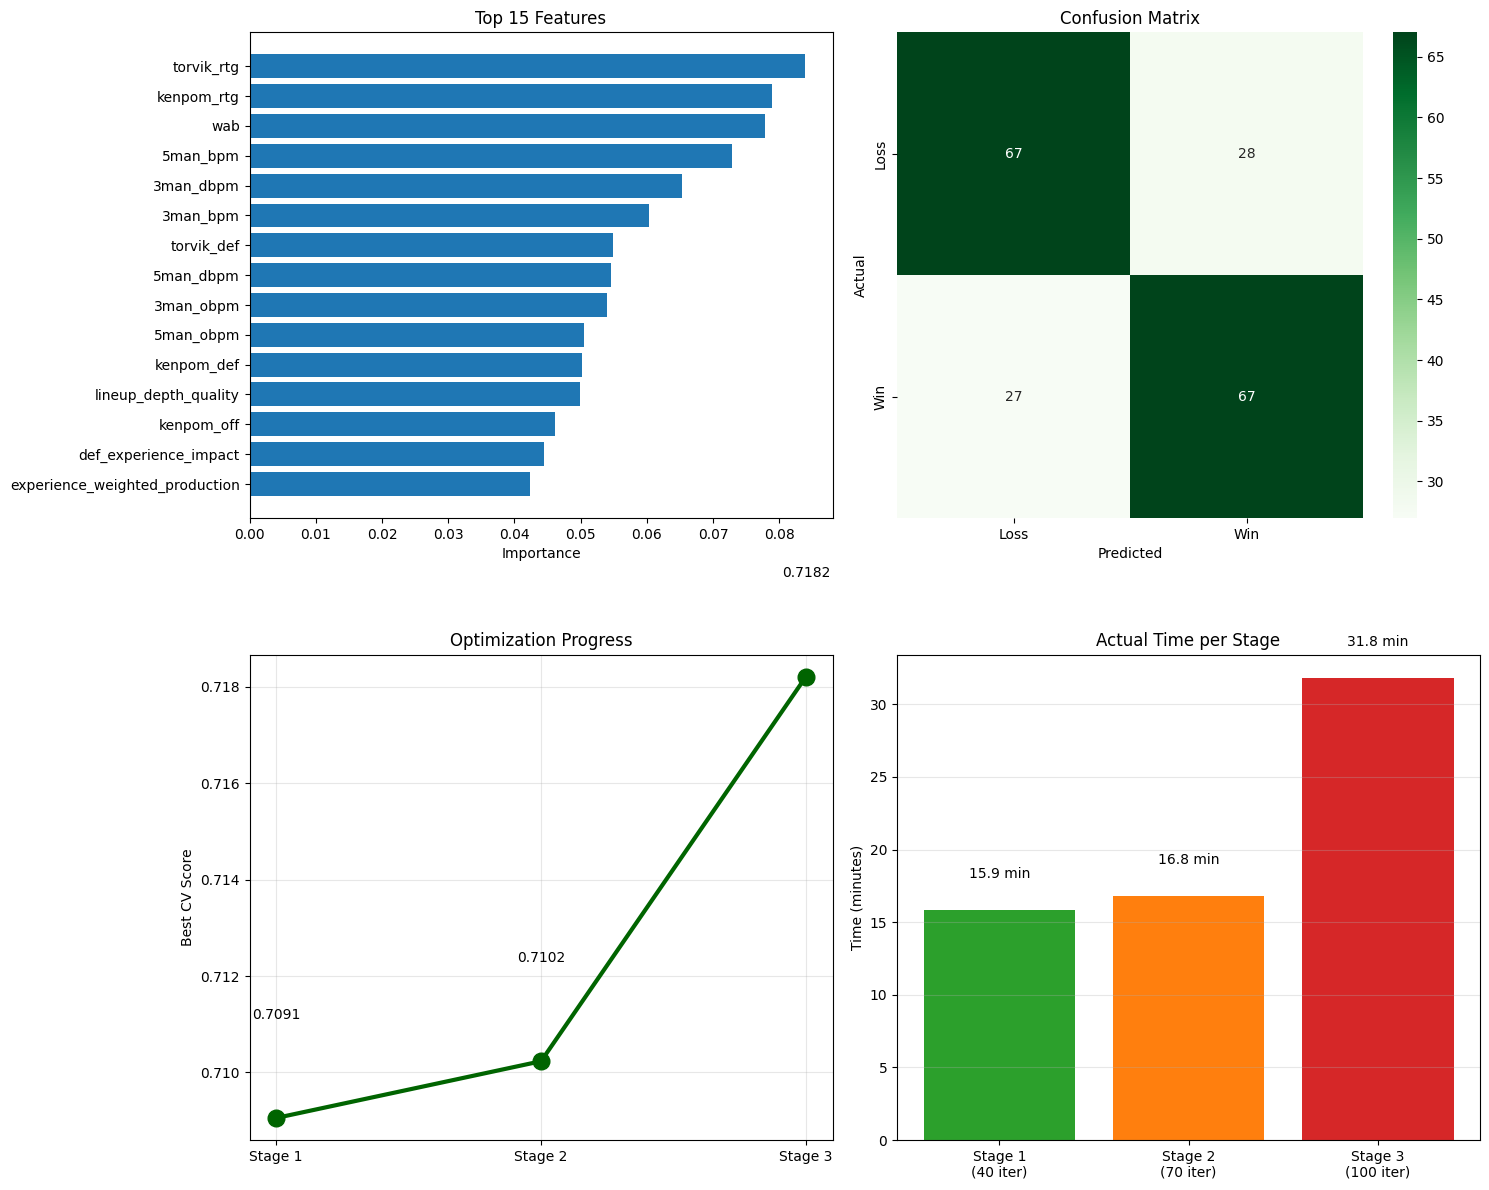


FINAL SUMMARY
Total combinations: 210
Total fits: 630
ACTUAL Total Time: 64.5 minutes (1.08 hours)

Stage breakdown:
  Stage 1: 15.9 min (0.26 hrs)
  Stage 2: 16.8 min (0.28 hrs)
  Stage 3: 31.8 min (0.53 hrs)

Test Accuracy: 0.7090 (70.90%)
Train-Test Gap: 0.0127
CV Stability: 0.0406

🎯 SUCCESS: Great model!

3-STAGE XGBoost COMPLETE! 🚀


In [6]:
# =============================================================================
# FINAL EVALUATION
# =============================================================================
print("\n" + "="*80)
print("TRAINING FINAL MODEL WITH EARLY STOPPING")
print("="*80 + "\n")

best_params_final = random_search_stage3.best_params_.copy()

final_model = xgb.XGBClassifier(
    **best_params_final,
    tree_method='hist',
    device='cuda',
    random_state=42,
    eval_metric='logloss',
    enable_categorical=False
)

final_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=False
)

print(f"Final model trained")

best_xgb = final_model

print("\n" + "="*80)
print("FINAL MODEL EVALUATION")
print("="*80 + "\n")

y_train_pred = best_xgb.predict(X_train_scaled)
y_val_pred = best_xgb.predict(X_val_scaled)
y_test_pred = best_xgb.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Performance Across All Stages:")
print(f"  Stage 1 CV: {random_search_stage1.best_score_:.4f}")
print(f"  Stage 2 CV: {random_search_stage2.best_score_:.4f}")
print(f"  Stage 3 CV: {random_search_stage3.best_score_:.4f}")
print(f"  Total Improvement: {random_search_stage3.best_score_ - random_search_stage1.best_score_:.4f}")

print(f"\nFinal Model Performance:")
print(f"  Training:   {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Validation: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"  Test:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print(f"\nOverfitting Analysis:")
print(f"  Train-Val Gap:  {train_accuracy - val_accuracy:.4f} ({(train_accuracy - val_accuracy)*100:.2f}%)")
print(f"  Train-Test Gap: {train_accuracy - test_accuracy:.4f} ({(train_accuracy - test_accuracy)*100:.2f}%)")

if train_accuracy - test_accuracy > 0.10:
    print("\n⚠️  SEVERE: Significant overfitting (>10%)")
elif train_accuracy - test_accuracy > 0.05:
    print("\n⚠️  WARNING: Moderate overfitting (5-10%)")
else:
    print("\n✓ Good generalization!")

print(f"\n{'='*80}")
print("Classification Report (Test):")
print("="*80)
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                Loss    Win")
print(f"Actual Loss     {cm[0,0]:4d}   {cm[0,1]:4d}")
print(f"       Win      {cm[1,0]:4d}   {cm[1,1]:4d}")

cv_scores = cross_val_score(best_xgb, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\n5-Fold CV: {cv_scores}")
print(f"Mean: {cv_scores.mean():.4f} | Std: {cv_scores.std():.4f}")

if cv_scores.std() > 0.05:
    print("⚠️  High variance")
else:
    print("✓ Stable model")

feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Features:")
print(feature_importance.head(10).to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

top_features = feature_importance.head(15)
axes[0, 0].barh(range(len(top_features)), top_features['importance'])
axes[0, 0].set_yticks(range(len(top_features)))
axes[0, 0].set_yticklabels(top_features['feature'])
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('Top 15 Features')
axes[0, 0].invert_yaxis()

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'], ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_xlabel('Predicted')

stage_scores = [
    random_search_stage1.best_score_,
    random_search_stage2.best_score_,
    random_search_stage3.best_score_
]
axes[1, 0].plot(['Stage 1', 'Stage 2', 'Stage 3'], stage_scores, marker='o', linewidth=3, markersize=12, color='darkgreen')
axes[1, 0].set_ylabel('Best CV Score')
axes[1, 0].set_title('Optimization Progress')
axes[1, 0].grid(True, alpha=0.3)
for i, score in enumerate(stage_scores):
    axes[1, 0].text(i, score + 0.002, f'{score:.4f}', ha='center', va='bottom')

stage_times = [stage1_time/60, stage2_time/60, stage3_time/60]
axes[1, 1].bar(['Stage 1\n(40 iter)', 'Stage 2\n(70 iter)', 'Stage 3\n(100 iter)'], stage_times, color=['#2ca02c', '#ff7f0e', '#d62728'])
axes[1, 1].set_ylabel('Time (minutes)')
axes[1, 1].set_title('Actual Time per Stage')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, t in enumerate(stage_times):
    axes[1, 1].text(i, t + 2, f'{t:.1f} min', ha='center', va='bottom')

plt.tight_layout()
plt.show()

total_time = stage1_time + stage2_time + stage3_time
total_combinations = 500 + 1000 + 2000
total_fits = (500 * 4) + (1000 * 4) + (2000 * 4)

print(f"\n{'='*80}")
print("FINAL SUMMARY")
print("="*80)
print(f"Total combinations: {total_combinations}")
print(f"Total fits: {total_fits}")
print(f"ACTUAL Total Time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)")
print(f"\nStage breakdown:")
print(f"  Stage 1: {stage1_time/60:.1f} min ({stage1_time/3600:.2f} hrs)")
print(f"  Stage 2: {stage2_time/60:.1f} min ({stage2_time/3600:.2f} hrs)")
print(f"  Stage 3: {stage3_time/60:.1f} min ({stage3_time/3600:.2f} hrs)")
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Train-Test Gap: {train_accuracy - test_accuracy:.4f}")
print(f"CV Stability: {cv_scores.std():.4f}")

if test_accuracy > 0.70 and train_accuracy - test_accuracy < 0.08:
    print(f"\n🎯 SUCCESS: Great model!")
elif test_accuracy > 0.65:
    print(f"\n✓ Good model")
else:
    print(f"\n⚠️  Could improve")

print("\n" + "="*80)
print("3-STAGE XGBoost COMPLETE! 🚀")
print("="*80)